<a href="https://colab.research.google.com/github/Nathan-Benz/BeginnerApp/blob/master/Distracted_Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distracted Driver Recognition
The data set for this project is split into two parts: `labels`, which includes all of the classes for our images and `image_data`, which has a 2-D representation of our images. The possible classes an image can take are:
* Attentive
* DrinkingCoffee
* UsingMirror
* UsingRadio



In [76]:
#@title Starter libraries (double click to take a look) { display-mode: "form" }
# useful for opening files
import gdown
import zipfile

import os # accessing parts of your operating system
import re
import sys

# data visualization + manipulation -- we've seen these many times
import numpy as np
import pandas as pd

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import linear_model

#Test code
from sklearn.datasets import fetch_openml
#Test code

from sklearn.preprocessing import PolynomialFeatures # for polynomial model
from sklearn.pipeline import Pipeline

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# more sklearn model making
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels

from collections import Counter

# NLP
import string
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords' ,quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import wordcloud
import tweepy

# NN models
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from tensorflow.keras import layers , activations , models , preprocessing, utils

# sequence data
from keras import Input, Model
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences

# text
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.text import Tokenizer

# NN and CNN
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.activations import softmax
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

import random

import warnings
warnings.filterwarnings('ignore')

#Model Metrics
!pip install pytorch-ignite
from ignite.engine import Engine
from ignite.metrics import Accuracy
import torch

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
#@title Load your dataset { display-mode: "form" }
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'

### pre-loading all data of interest
all_image_data = np.load('image_data.npy')
image_data = all_image_data.reshape((9037, 64,64,3))
metadata = pd.read_csv('metadata.csv')
labels = metadata['class']

print(all_image_data)

metadata.csv.4      100%[===================>] 200.33K  --.-KB/s    in 0.003s  
image_data.npy.4    100%[===================>] 423.61M   105MB/s    in 4.6s    
[[0.12156864 0.18431373 0.17254902 ... 0.0627451  0.08627451 0.04705883]
 [0.13725491 0.23137257 0.18039216 ... 0.09411766 0.1137255  0.13725491]
 [0.16470589 0.19215688 0.21568629 ... 0.00784314 0.0627451  0.07450981]
 ...
 [0.11764707 0.16862746 0.12941177 ... 0.04705883 0.07843138 0.08627451]
 [0.1137255  0.16078432 0.1137255  ... 0.07058824 0.0509804  0.03921569]
 [0.08235294 0.08235294 0.0509804  ... 0.02745098 0.02745098 0.01960784]]


Prints an image's numpy array

In [ ]:
image_data

Prints the class of the image

In [ ]:
print(metadata)

Selects a random image and shows image with label


Image number: 165
Class: UsingRadio


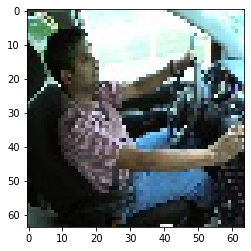

In [82]:
#Generate random number for image in range
num = random.randrange(0, 9037)

#Shows image and label
print("\nImage number:", num)
plt.imshow(image_data[num], cmap='gray')
print("Class:", labels[num])

Logistic Regression Starting Baseline

In [89]:
LRx = all_image_data
LRy = labels

#Split Model
LRx_train, LRx_test, LRy_train, LRy_test = train_test_split(LRx, LRy, test_size=0.2, random_state=9)
#Make Model, use 'saga' to make our model load faster
model = LogisticRegression(penalty='none',tol=0.1, solver='saga', multi_class='multinomial')
#Train Model
model.fit(LRx_train, LRy_train)
#Predict
LRy_pred = model.predict(LRx_test)
#Test Score
print("Logistic Regression Accuracy:")
print(accuracy_score(LRy_test, LRy_pred))

Logistic Regression Accuracy:
0.9684734513274337


Logistical Regresion Confusion Matrix

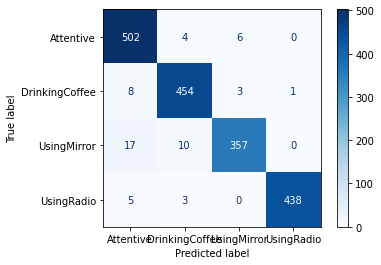

In [91]:
cm = confusion_matrix(LRy_test, LRy_pred, labels=["Attentive", "DrinkingCoffee", "UsingMirror", "UsingRadio"])

plot_confusion_matrix(model, LRx_test, LRy_test, cmap="Blues", labels=["Attentive", "DrinkingCoffee", "UsingMirror", "UsingRadio"])
plt.show()

Reshaping Data

In [56]:
x = image_data

#Load categories into Y
y = pd.get_dummies(metadata['class'])
#Turn categories into an array
y = y.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)

print("x train shape:", x_train.shape)
print("y train shape:", y_train.shape)
print("x test shape:", x_test.shape)
print("y test shape:", y_test.shape)

x train shape: (7229, 64, 64, 3)
y train shape: (7229, 4)
x test shape: (1808, 64, 64, 3)
y test shape: (1808, 4)


CNN Model

In [ ]:
#Keras Model
cnn_model = Sequential()

#Change up values, most definatly inpute_shape
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (64, 64, 3))) # layer 1
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')) # layer 2
cnn_model.add(MaxPooling2D(pool_size=(2,2))) # layer 3

#Dropout
cnn_model.add(Dropout(.25))

cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu')) # layer 4
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')) # layer 5
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # layer 6

cnn_model.add(Flatten()) # layer 7
cnn_model.add(Dense(256, activation = "relu")) # layer 8
cnn_model.add(Dense(4, activation = "softmax")) # layer 9

# Summarizes the model
cnn_model.summary()

CNN compilation and plot

In [60]:
# Compiles the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plots it
plot_acc(hist)

 82/226 [=========>....................] - ETA: 2:27 - loss: 2.4613e-07 - accuracy: 1.0000

KeyboardInterrupt: ignored